## FieldTrip sample data example
In this example we show processing of primate single unit data  
[made available in FieldTrip tutorial - add link here]  
[note that the original fieldtrip tutorial seems to be outdated - the results may not be the same; we also perform for example epoching differently ...]  
[some more info on the differences - fieldtrip tut seems to be out of date]

In [2]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import pylabianca as pln

%load_ext autoreload
%autoreload 2

We will read fieldtrip sample data and perform similar analyses to the fieldtrip spike-analysis tutorial. 
[info on how files were processed - just read in fieldtrip and saved for spike data]  
[events - slightly preprocessed, removed "empty" events]  

In [3]:
data_dir = r'C:\Users\ola kołodziej\Dropbox\Sarenka\PROJECTS\pylabianca\ft_data'
fname = 'p029_sort_final_01.mat'
full_path = op.join(data_dir, fname)

spk = pln.io.read_filedtrip(full_path)

Let's see a simple text description of the file.

In [4]:
spk

<Spikes, 21 cells, 201757.0 spikes/cell on average>

This is raw (non-epoched) data object with spikes data. [for more info about file formats see XXX example].  
Let's take a look at the unit names, this is stored in `.cell_names` property:

In [5]:
spk.cell_names

array(['sig001U', 'sig001a', 'sig002U', 'sig002a', 'sig003U', 'sig003a',
       'sig004U', 'sig001U_wf', 'sig001a_wf', 'sig002U_wf', 'sig002a_wf',
       'sig003U_wf', 'sig003a_wf', 'sig004U_wf', 'sig001U', 'sig001a',
       'sig002U', 'sig002a', 'sig003U', 'sig003a', 'sig004U'],
      dtype=object)

We will select a subset of units that contain waveform information. These units have `'_wf'` in their name.  
We will first collect the names of the units that we want to select (those with `'_wf'` in their name) and then use `.pick_cells()` method. This method works in place (so it will modify our `spk` object) and selects units either by their names or indices.

In [6]:
picks = [name for name in spk.cell_names if '_wf' in name]
spk.pick_cells(picks)

<Spikes, 7 cells, 302635.0 spikes/cell on average>

We will first take a look at the inter-spike intervals (ISI) of these units. We can use `pln.viz.plot_isi()` function for that. First we will do it for one unit only (using `picks` argument to specify unit name of index):

<Axes: title={'center': 'sig001U_wf'}, xlabel='ISI (ms)', ylabel='Count'>

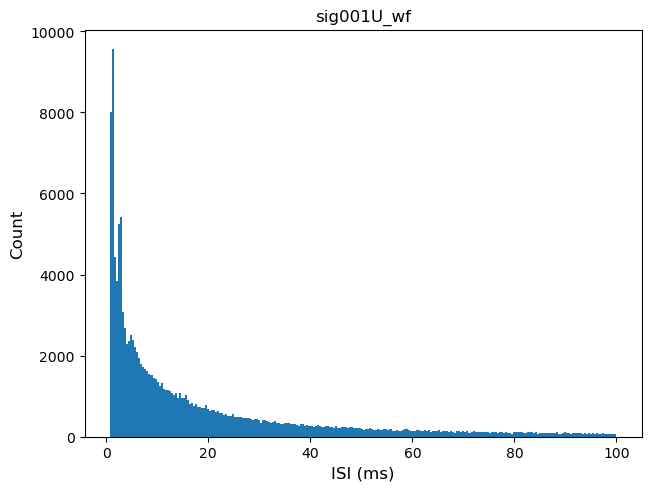

In [7]:
pln.viz.plot_isi(spk, picks=0)

The ISI histogram above suggests that it is a multiunit (many refractory period violations).  
We can plot ISI histograms for multiple units at once by providing a list or array of unit names / unit indices to `picks`.  
When we do not specify the `picks`, the function will try to plot histograms for all units. Below we also reduce the number of bins in the histograms (`bins=75`):

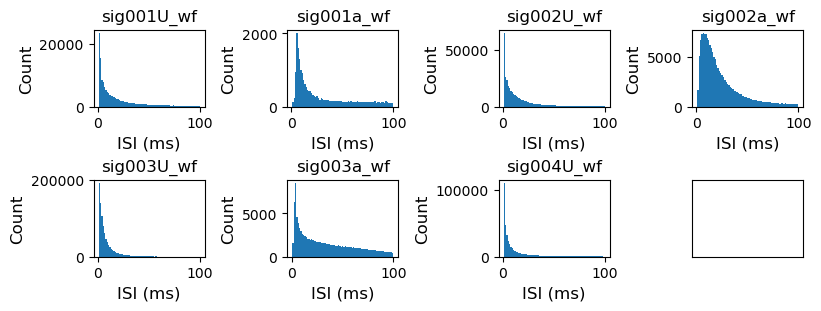

In [8]:
pln.viz.plot_isi(spk, bins=75);

[we can see that units with "U" in their file name are multi-unit - they violate refractory period] 
Loking at the ISI histograms we can see that for this dataset  
 units with names ending with 'U_wf' are multiunit  
Let's look at waveform for one of the single unitss

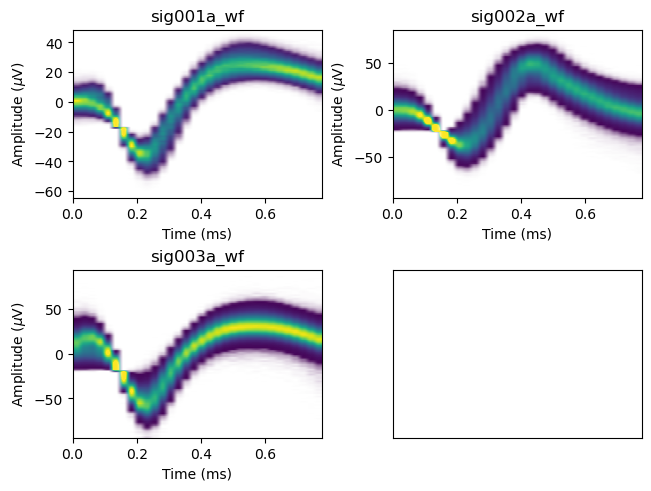

In [9]:
single_units = [name for name in spk.cell_names if not name.endswith('U_wf')]
spk.plot_waveform(picks=single_units);

We can see that waveforms for the sample fieldtrip spike data are not peak-aligned. We can realign them using `pln.utils.realign_wavefroms()`. This function also does some simple cleaning of the waveforms - rejecting the waveforms and corresponding spikes that are clearly incorrect (inspired by what is done by FieldTrip's `ft_spike_waveform`):

In [10]:
pln.utils.realign_waveforms(spk, picks=single_units)

Removing 723 bad waveforms for cellsig002a_wf.
Removing 28 bad waveforms for cellsig003a_wf.


(realigning waveforms works in-place too, so out Spikes object (`spk`) is modified now)

When plotting the waveforms by default they are shown in their original resolution - 32 samples each in the case here. We can upsample the waveforms to get a cleaner picture using `upsample` argument:

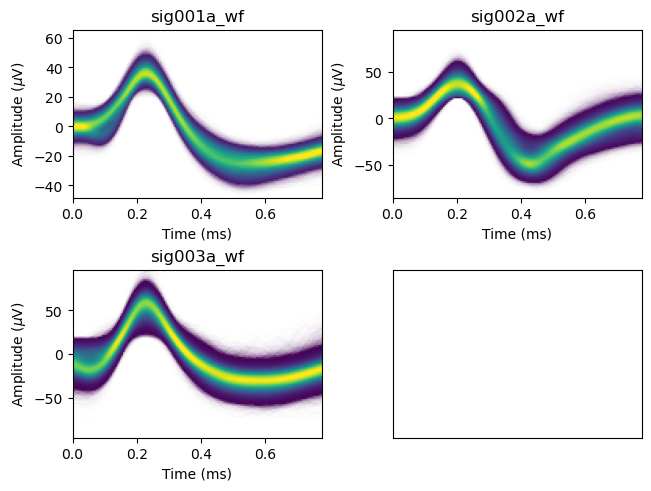

In [12]:
spk.plot_waveform(picks=single_units, upsample=5);

### Epoching Spikes
[some info about epoching and reading events etc.]

In [13]:
from scipy.io import loadmat

# we read matlab file with events
event_fname = 'p029_sort_final_01_events.mat'
events_mat = loadmat(
    op.join(data_dir, event_fname), squeeze_me=True)['event']

# and then format the events into mne-python events array
n_events = len(events_mat)
events = np.zeros((n_events, 3), dtype='int64')
events[:, 0] = events_mat['timestamp'].astype('int64')
events[:, -1] = events_mat['value'].astype('int64')

del events_mat

We've organized the events into default mne-python format: first column stores sample index (here timestamp), last column - event id:

In [14]:
events[:10]

array([[111204,      0,  10044],
       [111283,      0,      1],
       [111363,      0,  20001],
       [111444,      0,  10000],
       [121562,      0,  10001],
       [121642,      0,  10002],
       [121722,      0,  10003],
       [121802,      0,  10033],
       [121882,      0,  10008],
       [132001,      0,  10009]], dtype=int64)

we can use `.epoch()` method of `Spikes` to create `SpikeEpochs` - a data representation with multiple trials centered with respect to some event of interest  
According to FieldTrip tutorial trigger `10030` is "stimon" - most likely stimulus onset, so we epoch spikes with respect to this event:

In [15]:
spk_epochs = spk.epoch(events, event_id=10030, tmin=-0.5, tmax=1.)

We can now calculate peri-stimulus spike density. We specify the length of the gaussing kernel using full width at half-maximum (`fwhm` argument), but there are other ways to do so (`gauss_sd` and `windlen` - see the docstring of `.spike_density()` method): 

In [16]:
frate = spk_epochs.spike_density(fwhm=0.1)

Because the output of `.spike_density()` (and `.spike_rate()` too), is an xarray DataArray, we can use various convinient plotting options of xarray to visualize firing rate changes.  
Xarray arrays have named dimensions, so below you can see that when we take the mean of the trial dimension - we don't have to remember its numerical order, but just specify dimension name. After taking the mean `.plot()` methodd is used and the averages are plotted using different color for each cell (`hue='cell'`):

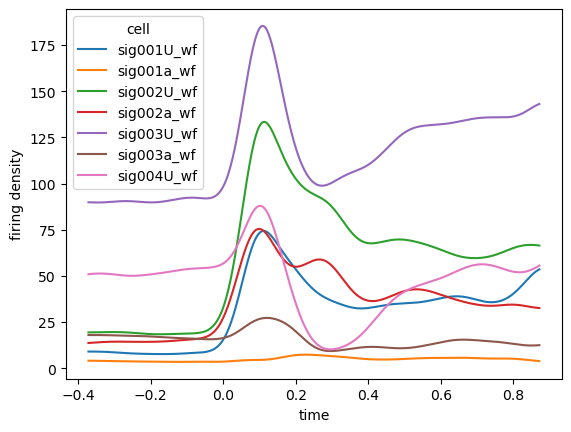

In [17]:
frate.mean(dim='trial').plot(hue='cell');

We can also first select a single cell by index (using the `.isel()` method) and then plot single-trial firing rate as a heatmap:

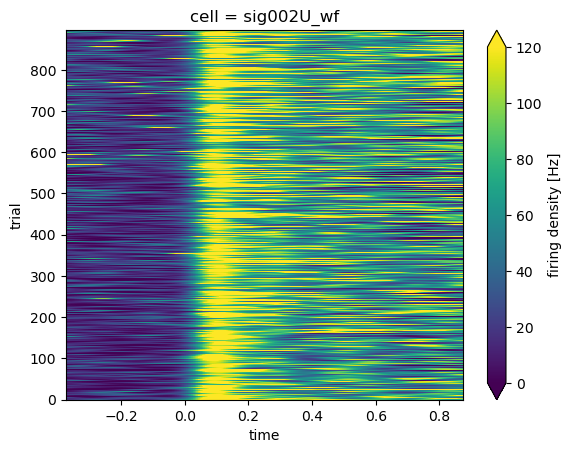

In [20]:
frate.isel(cell=2).plot(vmin=0, vmax=120);

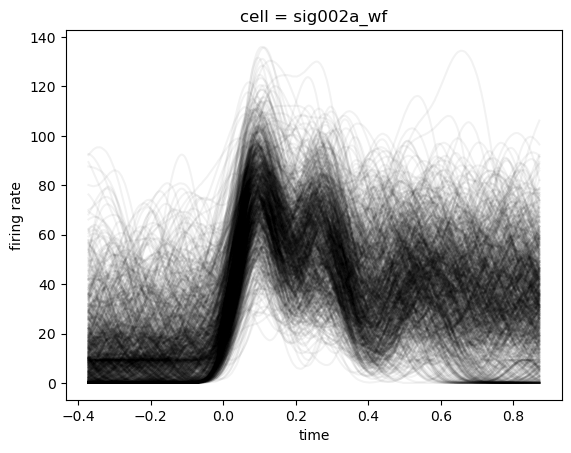

In [45]:
frate.isel(cell=3).plot(hue='trial', color='k', alpha=0.05, add_legend=False);

To plot the spiking with standard error of the mean shade we can use `pln.viz.plot_shaded`:

<Axes: title={'center': 'cell = sig001a_wf'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

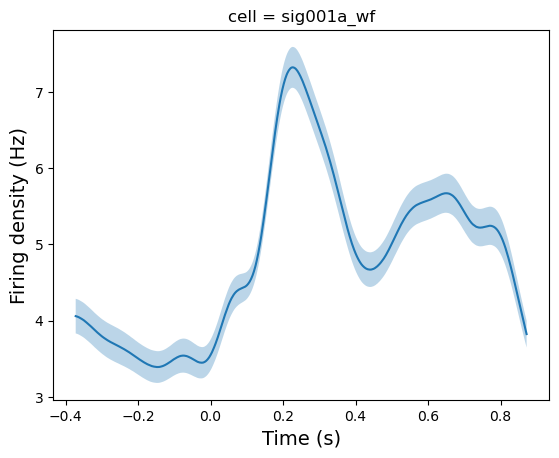

In [21]:
pln.viz.plot_shaded(frate.isel(cell=1))

<Axes: title={'center': 'cell = sig002a_wf'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

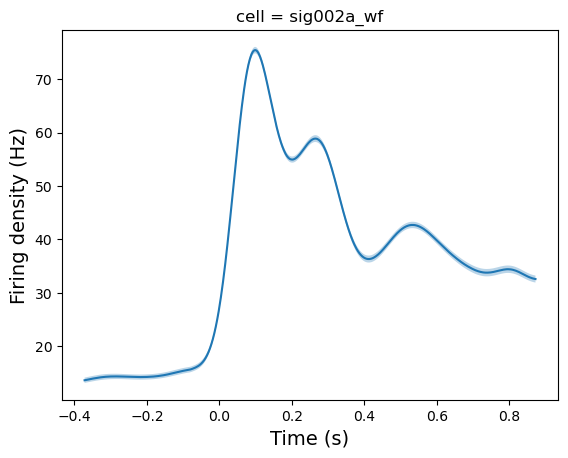

In [22]:
pln.viz.plot_shaded(frate.isel(cell=3))

### adding condition information

In [23]:

# TODO - add note that if one saves trial-by-trial output data table
#        then we could just read it in

# events 20001 - 20004 represent condtions
# "att in/out by target change first/second" as stated in FieldTrip tutorial
# but there are more condition events than "stimon" (10030) events
# therefore we find the closest preceding condition event to each stimon event
stimon_event = np.where(np.in1d(events[:, -1], [10030]))[0]
cond_event = np.where(np.in1d(events[:, -1], np.arange(20001, 20005)))[0]
event_diff = stimon_event[:, None] - cond_event[None, :]
event_diff[event_diff < 1] = event_diff.max()
cond_use = event_diff.argmin(axis=1)
conditions = events[cond_event[cond_use], -1]

then we construct condition dataframe

In [24]:
import pandas as pd
metadata = pd.DataFrame(index=np.arange(len(conditions)),
                        columns=['trigger', 'attention_in', 'target_first'])
attention_in = [20001, 20002]
target_change_first = [20001, 20003]

metadata.loc[:, 'trigger'] = conditions
metadata.loc[:, 'attention_in'] = np.in1d(conditions, attention_in)
metadata.loc[:, 'target_first'] = np.in1d(conditions, target_change_first)

metadata.head()

,trigger,attention_in,target_first
0,20001,True,True
1,20003,False,True
2,20004,False,False
3,20001,True,True
4,20001,True,True


In [25]:
spk_epochs.metadata = metadata
frate = spk_epochs.spike_density(fwhm=0.1)

<Axes: title={'center': 'cell = sig001U_wf, attention_in = True'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

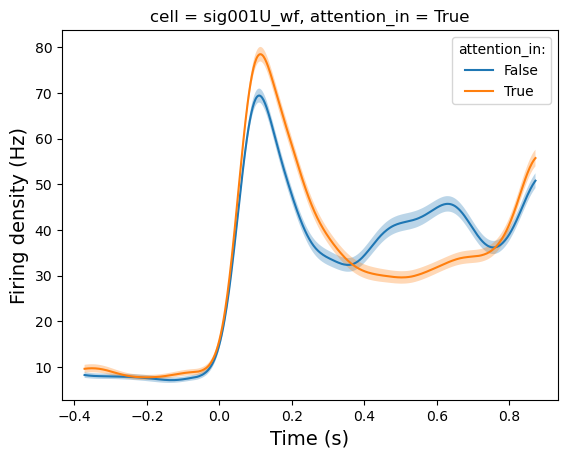

In [27]:
pln.viz.plot_shaded(frate.isel(cell=0), groupby='attention_in')

We can easily compute cluster-based permutation test to see if this difference is significant:

In [28]:
stats, clusters, pval = pln.stats.cluster_based_test(
    frate.isel(cell=0), compare='attention_in')

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 85.29it/s]


In [32]:
pval

array([0.   , 0.002, 0.628])

We see that cluster-level p value is < .05 in two cases. The difference between conditions can be judged as statistically significant. To visualise these clusters, and attached cluster-level p value, we will use `pln.viz.add_highlights()`:

<Axes: title={'center': 'cell = sig001U_wf, attention_in = True'}, xlabel='Time (s)', ylabel='Firing density (Hz)'>

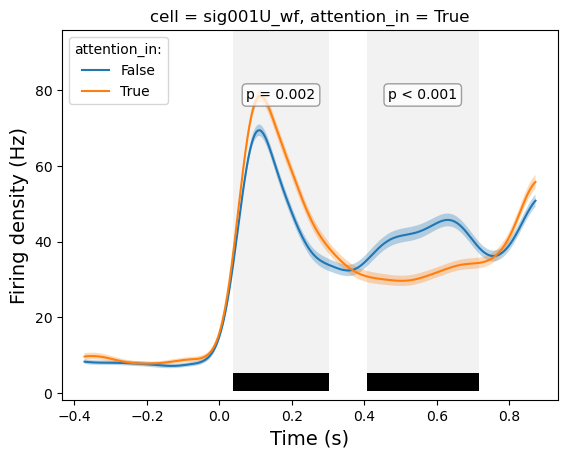

In [31]:
pln.viz.plot_shaded(frate.isel(cell=0), groupby='attention_in')
pln.viz.add_highlights(frate.isel(cell=0), clusters, pval)

## Cross-correlations
We can also take a look at pre-stimulus and post-stimulus auto / cross-correlations. We will do it shortly here.
We can compute cross-correlations by using `.xcorr()` method of SpikeEpochs: